<a href="https://colab.research.google.com/github/saleh1312/python/blob/master/Domain%20Adaptation%20tensorflow%202%20.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
import numpy as np
import pickle
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder as onehot

In [2]:
(xmnist, ymnist), (_,_P)= tf.keras.datasets.mnist.load_data()
xmnist=np.reshape(xmnist,(xmnist.shape[0],xmnist.shape[1],xmnist.shape[2],1))
xmnist=xmnist.astype(np.float32)
xmnist=np.concatenate((xmnist, xmnist,xmnist), axis=3)
ymnist=tf.keras.utils.to_categorical(ymnist)

11493376/11490434 [==============================] - 0s 0us/step


In [3]:
with open('/content/drive/MyDrive/keras_mnistm.pkl', 'rb') as f:
    u = pickle._Unpickler(f)
    u.encoding = 'latin1'
    p = u.load()
xmnistm=p['train']
xmnistm=xmnistm.astype(np.float32)

In [4]:
xm=xmnist.copy()
ym=ymnist.copy()
xmm=np.vstack([xmnist,xmnistm])
ymm=np.vstack([np.ones((60000,1)),np.zeros((60000,1))]).astype(np.float64)
ymm2=np.vstack([ym,ym])
ymm=tf.keras.utils.to_categorical(ymm)

In [5]:
xmm,ymm,ymm2=shuffle(xmm,ymm,ymm2)

In [6]:
class FeatureGenerator(tf.keras.Model):
  def __init__(self):
    super(FeatureGenerator, self).__init__() 
    self.normalise = lambda x:x / 255.0
    self.conv1 = tf.keras.layers.Conv2D(64, 5, activation='relu')
    self.conv2 = tf.keras.layers.Conv2D(128, 5, activation='relu')
    self.maxpool = tf.keras.layers.MaxPool2D(2)
    self.flatten = tf.keras.layers.Flatten()
    
  def call(self, x):
    x = self.normalise(x)
    x = self.conv1(x)
    x = self.conv2(x)
    x = self.maxpool(x)

    return self.flatten(x)

encoder = FeatureGenerator()

In [7]:
class label(tf.keras.Model):
  def __init__(self):
    super(label, self).__init__() 

    self.d1 = tf.keras.layers.Dense(128,activation='relu')
    self.d2 = tf.keras.layers.Dense(10,activation='softmax')
    
  def call(self, x):
    x = self.d1(x)
    x = self.d2(x)
    return x

clas = label()

In [8]:
class domain(tf.keras.Model):
  def __init__(self):
    super(domain, self).__init__() 

    self.d1 = tf.keras.layers.Dense(64,activation='relu')
    self.d2 = tf.keras.layers.Dense(2,activation='softmax')
    
  def call(self, x):
    x = self.d1(x)
    x = self.d2(x)
    return x

dis = domain()

In [9]:
mnsistmacc=tf.keras.metrics.CategoricalAccuracy()
mnsistacc=tf.keras.metrics.CategoricalAccuracy()
loss=tf.keras.losses.CategoricalCrossentropy()
d_optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
f_optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
c_optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

In [10]:
def train_step(x1,y1,x2,y2,alpha=0.5):
  with tf.GradientTape() as tapegc ,tf.GradientTape() as tapegd , tf.GradientTape() as tapec:
    ff=encoder(x1, training=True)
    yc=clas(ff, training=True)
    lossc=loss(y1,yc)

    ff2=encoder(x2, training=True)
    yc2=dis(ff2, training=True)
    lossd=loss(y2,yc2)

  f_gradients_on_label_loss = tapegc.gradient(lossc, encoder.trainable_variables)
  f_gradients_on_domain_loss = tapegd.gradient(lossd, encoder.trainable_variables)    
  f_gradients = [f_gradients_on_label_loss[i] - alpha*f_gradients_on_domain_loss[
      i] for i in range(len(f_gradients_on_domain_loss))]

    
  l_gradients = tapec.gradient(lossc, clas.trainable_variables)

  f_optimizer.apply_gradients(zip(f_gradients+l_gradients, 
                                  encoder.trainable_variables+clas.trainable_variables)) 
  
  with tf.GradientTape() as taped:
    features = encoder(x2, training=True)
    d_predictions = dis(features, training=True)
    domain_loss = loss(y2, d_predictions)
  #####
   
  d_gradients = taped.gradient(domain_loss, dis.trainable_variables)  
  d_gradients = [alpha*i for i in d_gradients]
  d_optimizer.apply_gradients(zip(d_gradients, dis.trainable_variables))

In [11]:
def test(x1,x2,y):
  d=encoder(x1)
  c=clas(d)
  mnsistacc.update_state(y,c)
  d=encoder(x2)
  c=clas(d)
  mnsistmacc.update_state(y,c)

In [20]:
def train(epochs):
  for e in range(epochs):
    mnsistmacc.reset_state()
    mnsistacc.reset_state()
    for i in range(0,60000,32):
      x1=xm[i:i+32]
      y1=ym[i:i+32]
      x2=xmm[i:i+32]
      y2=ymm[i:i+32]
      train_step(x1,y1,x2,y2)

    for i in range(0,5000,100):
      x1=xmnist[i:i+100]
      x2=xmnistm[i:i+100]
      y=ymnist[i:i+100]
      test(x1,x2,y)
    template = 'Epoch {}, mnist Accuracy: {} , mnist-m Accuracy: {}'
    if e%1 == 0:
      print(template.format(e+1,mnsistacc.result()*100,mnsistmacc.result()*100))

In [21]:
train(100)

Epoch 1, mnist Accuracy: 32.0 , mnist-m Accuracy: 13.160000801086426
Epoch 2, mnist Accuracy: 74.81999969482422 , mnist-m Accuracy: 12.620000839233398
Epoch 3, mnist Accuracy: 93.9000015258789 , mnist-m Accuracy: 25.700000762939453
Epoch 4, mnist Accuracy: 95.44000244140625 , mnist-m Accuracy: 38.0
Epoch 5, mnist Accuracy: 97.41999816894531 , mnist-m Accuracy: 44.18000030517578
Epoch 6, mnist Accuracy: 98.0199966430664 , mnist-m Accuracy: 41.220001220703125
Epoch 7, mnist Accuracy: 97.93999481201172 , mnist-m Accuracy: 57.720001220703125
Epoch 8, mnist Accuracy: 97.75999450683594 , mnist-m Accuracy: 64.9800033569336
Epoch 9, mnist Accuracy: 97.68000030517578 , mnist-m Accuracy: 66.0199966430664
Epoch 10, mnist Accuracy: 97.13999938964844 , mnist-m Accuracy: 66.6199951171875
Epoch 11, mnist Accuracy: 97.63999938964844 , mnist-m Accuracy: 70.16000366210938
Epoch 12, mnist Accuracy: 98.0 , mnist-m Accuracy: 72.86000061035156
Epoch 13, mnist Accuracy: 97.57999420166016 , mnist-m Accuracy: 

KeyboardInterrupt: ignored

[4]
4


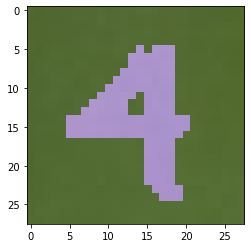

In [32]:
o=34000
preds=encoder(np.reshape(xmnistm[o],(1,28,28,3)))
preds=clas(preds)
print(np.argmax(preds,1))
print(np.argmax(ymnist[o]))
plt.imshow(xmnistm[o]/255)